In [46]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import arviz as az
from scipy.optimize import minimize, brentq
from scipy.stats import norm, probplot, weibull_min, gamma, lognorm
from IPython.display import Markdown, display
from reliability.Fitters import Fit_Everything

K_BOLTZ_eV = 8.617333262e-5  # eV/K


class Fit_ADT_sqrt_Arrhenius:
    """
    Fit a sqrt-time + Arrhenius degradation model to ADT data.

        D(t, T) = g0 + g1 * sqrt(t) * exp(Ea / k * (1/T_use - 1/T))

    Parameters
    ----------
    degradation : array-like
        Observed degradation values D_ij.
    stress : array-like
        Temperature in degrees Celsius for each observation.
    time : array-like
        Time in the same units used in the model (e.g. hours).
    stress_use : float
        Use temperature in degrees Celsius.
    CI : float, default 0.95
        Confidence level for parameter intervals and noise bands.
    method : {"LS", "MLE", "MLE_hierarchical", "Bayesian"}, default "MLE"
        Fitting approach.
    noise : {"additive", "multiplicative"}, default "additive"
        Stochastic error model for MLE/Bayesian fits.
    show_data_plot : bool, default False
        If True, plot raw degradation vs time, coloured by temperature.
    show_LSQ_diagnostics : bool, default False
        If True and method=="LS" (or for LS pre-fit in MLE), show residual diagnostics.
    show_noise_bounds : bool, default True
        If True and method=="MLE", plot mean curve with noise bands.
    print_results : bool, default True
        If True, print parameter estimates and (approximate) CIs.
    **kwargs :
        Reserved for future extensions (e.g., optimizer options).
    """

    def __init__(
        self,
        degradation,
        stress,
        time,
        unit,
        stress_use,
        Df,
        CI=0.95,
        method="MLE",
        noise="additive",
        show_data_plot=False,
        show_LSQ_diagnostics=False,
        show_noise_bounds=True,
        show_use_TTF_dist=False,
        print_results=True,
        **kwargs,
    ):

        # --- Basic data housekeeping ---
        self.D = np.asarray(degradation, dtype=float).ravel()
        self.T_C = np.asarray(stress, dtype=float).ravel()
        self.t = np.asarray(time, dtype=float).ravel()
        self.unit = np.asarray(unit, int).ravel()
        if not (self.unit.shape == self.D.shape == self.T_C.shape == self.t.shape):
            raise ValueError("unit, degradation, stress, and time must all match in shape.")

        self.unique_units, self.unit_index = np.unique(self.unit, return_inverse=True)
        self.J = len(self.unique_units)
        self.T_K = self.T_C + 273.15
        self.T_use_C = float(stress_use)
        self.T_use_K = self.T_use_C + 273.15

        self.CI = CI
        self.alpha = 1.0 - CI
        self.z_CI = norm.ppf(0.5 + CI / 2.0)
        self.Df_use = float(Df)
        self.method = method
        self.noise = noise.lower()
        self.show_data_plot = show_data_plot
        self.show_LSQ_diagnostics = show_LSQ_diagnostics
        self.show_noise_bounds = show_noise_bounds
        self.show_use_TTF_dist = show_use_TTF_dist
        self.print_results = print_results
        self.kwargs = kwargs

        # Storage for parameter estimates
        self.theta_LS = None        # (g0, g1, Ea)
        self.sigma_LS = None        # residual std from LS
        self.cov_LS = None

        self.theta_MLE = None       # (g0, g1, Ea)
        self.sigma_MLE = None
        self.cov_MLE = None

        # --- Optional raw data plot ---
        if self.show_data_plot:
            self._plot_data()

        # --- Fit according to chosen method ---
        method_norm = method.lower()
        if method_norm == "ls":
            self._fit_LS(suppress_print=False)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._plot_fit_LS()

        elif method_norm == "mle":
            self._fit_LS(suppress_print=True)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._fit_MLE()
            self._plot_fit_MLE()
            if self.show_use_TTF_dist:
                # option: include_param_uncertainty=True if you want MVN sampling
                self._plot_use_TTF_distribution(source="mle",
                                                include_param_uncertainty=False)

        elif method_norm in ("mle_hierarchical", "mle_heirachical"):
            self._fit_LS(suppress_print=True)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._fit_MLE_hierarchical()
            self._plot_fit_MLE_hierarchical()

        elif method_norm in ("bayesian"):
            self._fit_LS(suppress_print=True)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._fit_Bayesian()
            self._plot_fit_Bayesian()
            if self.show_use_TTF_dist:
                self._plot_use_TTF_distribution(source="bayes")

        else:
            raise ValueError(f"Unknown method: {method}")

    # ------------------------------------------------------------------
    # Model helpers
    # ------------------------------------------------------------------

    @staticmethod
    def _accel_factor_from_params(T_use_K, T_K, Ea):
        return np.exp(Ea / K_BOLTZ_eV * (1.0 / T_use_K - 1.0 / T_K))

    @staticmethod
    def _mu_D(theta, t, T_K, T_use_K):
        g0, g1, Ea = theta
        accel = Fit_ADT_sqrt_Arrhenius._accel_factor_from_params(T_use_K, T_K, Ea)
        return g0 + g1 * np.sqrt(t) * accel

    # ------------------------------------------------------------------
    # LS fit
    # ------------------------------------------------------------------
    def _init_guess(self):
        # Rough-and-ready initial guesses
        g0_init = float(np.percentile(self.D, 10))
        span = max(np.percentile(self.D, 90) - g0_init, 1e-6)
        g1_init = span / max(np.sqrt(self.t.max()), 1.0)
        Ea_init = 0.7  # eV, generic-ish starter
        return np.array([g0_init, g1_init, Ea_init])

    def _ls_objective(self, theta):
        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)
        resid = self.D - mu
        return np.sum(resid ** 2)

    def _fit_LS(self, suppress_print=False):
        theta0 = self._init_guess()

        bounds = [
            (None, None),   # g0
            (1e-10, None),  # g1 > 0
            (1e-3, 5.0),    # Ea in [0.001, 5] eV
        ]

        res = minimize(
            self._ls_objective,
            theta0,
            method="L-BFGS-B",
            bounds=bounds,
        )

        if not res.success:
            print("Warning: LS fit did not converge:", res.message)

        self.theta_LS = res.x
        mu = self._mu_D(self.theta_LS, self.t, self.T_K, self.T_use_K)
        resid = self.D - mu
        dof = max(len(self.D) - len(self.theta_LS), 1)
        self.sigma_LS = np.sqrt(np.sum(resid ** 2) / dof)

        # Approximate covariance from inverse Hessian
        hess_inv = getattr(res, "hess_inv", None)
        if hasattr(hess_inv, "todense"):
            self.cov_LS = np.array(hess_inv.todense())
        elif isinstance(hess_inv, np.ndarray) and hess_inv.ndim == 2:
            self.cov_LS = hess_inv
        else:
            self.cov_LS = None

        # Only print if not being used as a silent initializer
        if self.print_results and not suppress_print:
            self._print_param_table(
                self.theta_LS,
                self.cov_LS,
                sigma=self.sigma_LS,
                label="LSQ"
            )

    # ------------------------------------------------------------------
    # MLE fit
    # ------------------------------------------------------------------
    def _negloglik_additive(self, params):
        g0, g1, Ea, log_sigma = params
        sigma = np.exp(log_sigma)

        theta = np.array([g0, g1, Ea])
        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)

        # Guardrails
        if sigma <= 0 or not np.all(np.isfinite(mu)):
            return np.inf

        return -np.sum(norm.logpdf(self.D, loc=mu, scale=sigma))

    def _negloglik_multiplicative(self, params):
        g0, g1, Ea, log_sigma = params
        sigma = np.exp(log_sigma)
        theta = np.array([g0, g1, Ea])

        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)
        # Need positive mean and observed values for lognormal error
        D_pos = np.clip(self.D, 1e-12, None)
        mu_pos = np.clip(mu, 1e-12, None)

        logD = np.log(D_pos)
        logmu = np.log(mu_pos)

        if sigma <= 0 or not np.all(np.isfinite(logmu)):
            return np.inf

        return -np.sum(norm.logpdf(logD, loc=logmu, scale=sigma))

    def _fit_MLE(self):
        if self.theta_LS is None:
            raise RuntimeError("LS fit must be performed before MLE.")

        g0_LS, g1_LS, Ea_LS = self.theta_LS
        sigma0 = self.sigma_LS if self.sigma_LS is not None else np.std(self.D)
        params0 = np.array([g0_LS, g1_LS, Ea_LS, np.log(sigma0 + 1e-6)])

        if self.noise == "additive":
            fun = self._negloglik_additive
        elif self.noise == "multiplicative":
            fun = self._negloglik_multiplicative
        else:
            raise ValueError("noise must be 'additive' or 'multiplicative'.")

        bounds = [
            (None, None),   # g0
            (1e-10, None),  # g1
            (1e-3, 5.0),    # Ea
            (np.log(1e-6), np.log(1e3)),  # log_sigma
        ]

        res = minimize(
            fun,
            params0,
            method="L-BFGS-B",
            bounds=bounds,
        )

        if not res.success:
            print("Warning: MLE fit did not converge:", res.message)

        g0, g1, Ea, log_sigma = res.x
        self.theta_MLE = np.array([g0, g1, Ea])
        self.sigma_MLE = float(np.exp(log_sigma))

        # Approximate covariance
        hess_inv = getattr(res, "hess_inv", None)
        if hasattr(hess_inv, "todense"):
            self.cov_MLE = np.array(hess_inv.todense())
        elif isinstance(hess_inv, np.ndarray) and hess_inv.ndim == 2:
            self.cov_MLE = hess_inv
        else:
            self.cov_MLE = None

        if self.print_results:
            self._print_param_table(
                self.theta_MLE,
                self.cov_MLE,
                sigma=self.sigma_MLE,
                label=f"MLE ({self.noise})"
            )
            
    # ------------------------------------------------------------------
    # Bayesian stub (so you can plug in your existing code)
    # ------------------------------------------------------------------

    def _fit_Bayesian(self, nwalkers=32, nburn=1000, nsamp=2000):
        """
        Simple Bayesian fit using emcee with log-normal priors on (g0, g1, Ea, sigma).
    
        Stores posterior samples in:
            self.g0_s, self.g1_s, self.Ea_s, self.sigma_s
        and prints posterior means.
        """
        # Ensure we have MLE before Bayesian
        if self.theta_MLE is None or self.sigma_MLE is None:
            # Compute MLE silently
            ls_print = self.print_results
            self.print_results = False
            self._fit_MLE()
            self.print_results = ls_print
        if self.theta_MLE is not None and self.sigma_MLE is not None:
            g0_hat, g1_hat, Ea_hat = self.theta_MLE
            sig_hat = self.sigma_MLE
        elif self.theta_LS is not None and self.sigma_LS is not None:
            g0_hat, g1_hat, Ea_hat = self.theta_LS
            sig_hat = self.sigma_LS
        else:
            raise RuntimeError("Run LS or MLE first to initialise Bayesian priors.")
    
        # Log-space prior centres and scales
        mu_logg0 = np.log(max(g0_hat, 1e-10))
        mu_logg1 = np.log(max(g1_hat, 1e-10))
        mu_logEa = np.log(max(Ea_hat, 1e-3))
        mu_logs  = np.log(max(sig_hat, 1e-6))
    
        sd_logg0 = 0.5
        sd_logg1 = 0.5
        sd_logEa = 0.5
        sd_logs  = 0.5
    
        # Data for likelihood
        t_time  = self.t
        T_acc_K = self.T_K
        D_obs   = self.D
    
        # --------- Priors & likelihood in log-space ----------
        def log_prior(theta):
            log_g0, log_g1, log_Ea, log_sig = theta
    
            lp  = -0.5*((log_g0 - mu_logg0)/sd_logg0)**2 - np.log(sd_logg0*np.sqrt(2*np.pi))
            lp += -0.5*((log_g1 - mu_logg1)/sd_logg1)**2 - np.log(sd_logg1*np.sqrt(2*np.pi))
            lp += -0.5*((log_Ea - mu_logEa)/sd_logEa)**2 - np.log(sd_logEa*np.sqrt(2*np.pi))
            lp += -0.5*((log_sig - mu_logs)/sd_logs)**2   - np.log(sd_logs*np.sqrt(2*np.pi))
            return lp
    
        def log_likelihood(theta):
            log_g0, log_g1, log_Ea, log_sig = theta
            g0     = np.exp(log_g0)
            g1     = np.exp(log_g1)
            Ea     = np.exp(log_Ea)
            sigma  = np.exp(log_sig)
            params = np.array([g0, g1, Ea])
    
            if self.noise == "additive":
                mu = self._mu_D(params, t_time, T_acc_K, self.T_use_K)
                if sigma <= 0 or not np.all(np.isfinite(mu)):
                    return -np.inf
                return np.sum(norm.logpdf(D_obs, loc=mu, scale=sigma))
    
            elif self.noise == "multiplicative":
                mu = self._mu_D(params, t_time, T_acc_K, self.T_use_K)
                D_pos = np.clip(D_obs, 1e-12, None)
                mu_pos = np.clip(mu, 1e-12, None)
                logD   = np.log(D_pos)
                logmu  = np.log(mu_pos)
                if sigma <= 0 or not np.all(np.isfinite(logmu)):
                    return -np.inf
                # Lognormal: logD ~ N(logmu, sigma^2)
                z = (logD - logmu) / sigma
                return (
                    -np.sum(np.log(D_pos))
                    - len(D_pos)*np.log(sigma)
                    + np.sum(norm.logpdf(z))
                )
            else:
                return -np.inf
    
        def log_prob(theta):
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            ll = log_likelihood(theta)
            if not np.isfinite(ll):
                return -np.inf
            return lp + ll
    
        # --------- Initialise walkers around MLE/LS in log-space ----------
        init = np.array([
            mu_logg0,
            mu_logg1,
            mu_logEa,
            mu_logs
        ])
    
        ndim = 4
        rng = np.random.default_rng(123)
        p0 = init + rng.normal(scale=[0.2, 0.2, 0.2, 0.2], size=(nwalkers, ndim))
    
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    
        # Burn-in
        state = sampler.run_mcmc(p0, nburn, progress=True)
        sampler.reset()
    
        # Sampling
        sampler.run_mcmc(state, nsamp, progress=True)
    
        chain = sampler.get_chain(flat=True)
        log_g0_s, log_g1_s, log_Ea_s, log_sig_s = chain.T
    
        self.g0_s    = np.exp(log_g0_s)
        self.g1_s    = np.exp(log_g1_s)
        self.Ea_s    = np.exp(log_Ea_s)
        self.sigma_s = np.exp(log_sig_s)
    
        # Optional: convert to ArviZ InferenceData for plotting
        try:
            import arviz as az
            idata = az.from_emcee(
                sampler,
                var_names=["g0", "g1", "Ea", "sigma"]
            )
            self.idata_bayes = idata
        except ImportError:
            self.idata_bayes = None
    
        # Quick summary
        g0_mean    = np.mean(self.g0_s)
        g1_mean    = np.mean(self.g1_s)
        Ea_mean    = np.mean(self.Ea_s)
        sigma_mean = np.mean(self.sigma_s)
    
        if self.print_results:
            self._print_bayes_param_table(
                {
                    "g0": self.g0_s,
                    "g1": self.g1_s,
                    "Ea (eV)": self.Ea_s,
                    r"$\sigma$": self.sigma_s,
                },
                label=f"Bayesian ({self.noise})"
            )

    # ------------------------------------------------------------------
    # Hierarchical MLE
    # ------------------------------------------------------------------
    def _fit_MLE_hierarchical(self):
        """
        Hierarchical MLE using internal log-joint model.

        Uses:
        - self._hier_init_theta0() for initial theta (unless hier_theta0 provided in kwargs)
        - self._neg_log_joint_hier() as objective
        - self._unpack_theta_hier() to store structured results

        Supports:
        - additive noise: Normal errors on D
        - multiplicative noise: lognormal errors on D
        """
        # Optionally allow override of theta0 via kwargs
        theta0 = self.kwargs.get("hier_theta0", None)
        if theta0 is None:
            theta0 = self._hier_init_theta0()

        res = minimize(
            self._neg_log_joint_hier,
            np.asarray(theta0, float),
            method="L-BFGS-B",
        )

        if not res.success:
            print("Warning: hierarchical MLE did not converge:", res.message)

        self.theta_hier = res.x
        self.res_hier = res

        (self.mu_g0_mle, self.sig_g0_mle,
         self.mu_g1_mle, self.sig_g1_mle,
         self.mu_Ea_mle, self.sig_Ea_mle,
         self.sigma_y_hier_mle,
         self.gamma0_j_mle,
         self.gamma1_j_mle,
         self.Ea_j_mle) = self._unpack_theta_hier(self.theta_hier)

        if self.print_results:
            from IPython.display import Markdown, display

            # Extract population parameters
            mu_g0  = self.mu_g0_mle
            sig_g0 = self.sig_g0_mle

            mu_g1  = self.mu_g1_mle
            sig_g1 = self.sig_g1_mle

            mu_Ea  = self.mu_Ea_mle
            sig_Ea = self.sig_Ea_mle

            sigma_y = self.sigma_y_hier_mle

            # Compute CI bounds: mean ± z * std
            CI_pct = int(self.CI * 100)

            def ci(mu, sd):
                lo = mu - self.z_CI * sd
                hi = mu + self.z_CI * sd
                return f"[{lo:.3g}, {hi:.3g}]"

            lines = []
            lines.append(f"### Hierarchical MLE Population Parameters ({CI_pct}% CI)\n")
            lines.append(f"| Parameter | Mean Estimate | STD | {CI_pct}% CI |")
            lines.append(f"|-----------|----------------|------|----------------|")
            lines.append(f"| $\gamma_0$ | {mu_g0:.6g} | {sig_g0:.6g} | {ci(mu_g0, sig_g0)} |")
            lines.append(f"| $\gamma_1$ | {mu_g1:.6g} | {sig_g1:.6g} | {ci(mu_g1, sig_g1)} |")
            lines.append(f"| $E_a$ (eV) | {mu_Ea:.6g} | {sig_Ea:.6g} | {ci(mu_Ea, sig_Ea)} |")
            lines.append(f"| $\\sigma_y$ (log D) | {sigma_y:.6g} | N/A | {ci(sigma_y, sigma_y)} |")

            display(Markdown("\n".join(lines)))

    def _unpack_theta_hier(self, theta):
        """
        theta = [mu_g0, log_sig_g0,
                 mu_g1, log_sig_g1,
                 mu_Ea, log_sig_Ea,
                 log_sigma_obs,
                 gamma0_0..J-1, gamma1_0..J-1, Ea_0..J-1]
        """
        J = self.J
        idx = 0
        mu_g0, log_sig_g0 = theta[idx], theta[idx+1]; idx += 2
        mu_g1, log_sig_g1 = theta[idx], theta[idx+1]; idx += 2
        mu_Ea, log_sig_Ea = theta[idx], theta[idx+1]; idx += 2
        log_sigma_obs     = theta[idx];               idx += 1
    
        gamma0_j = theta[idx       : idx+J]; idx += J
        gamma1_j = theta[idx       : idx+J]; idx += J
        Ea_j     = theta[idx       : idx+J]; idx += J
    
        sig_g0  = np.exp(log_sig_g0)
        sig_g1  = np.exp(log_sig_g1)
        sig_Ea  = np.exp(log_sig_Ea)
        sigma_y = np.exp(log_sigma_obs)
    
        return (mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea, sigma_y, gamma0_j, gamma1_j, Ea_j)
    
    def _mu_D_unit(self, theta_j, t, T_K):
        """
        Use the main class degradation model for unit-level parameters.
        """
        return Fit_ADT_sqrt_Arrhenius._mu_D(theta_j, t, T_K, self.T_use_K)

    def _log_likelihood_lognormal(self, D_vec, mu_vec, sigma):
        """
        Log-likelihood for lognormal observation error:
            ln(y) = ln(D) + eps, eps ~ N(0, sigma^2)
    
        p(y|D,sigma) = 1/(y*sigma) * phi((ln(y)-ln(D))/sigma)
        """
        if sigma <= 0:
            return -np.inf
        if np.any(D_vec <= 0) or np.any(mu_vec <= 0):
            return -np.inf
    
        z = (np.log(D_vec) - np.log(mu_vec)) / sigma
        return (-np.sum(np.log(D_vec)) - len(mu_vec) * np.log(sigma) + np.sum(norm.logpdf(z)))
        
    def _log_likelihood_normal(self, D_vec, mu_vec, sigma):
        """
        Log-likelihood for additive Normal observation error:
            D = mu + eps, eps ~ N(0, sigma^2)
        """
        if sigma <= 0:
            return -np.inf
        if not np.all(np.isfinite(mu_vec)):
            return -np.inf
    
        return np.sum(norm.logpdf(D_vec, loc=mu_vec, scale=sigma))


    def _log_joint_hier(self, theta):
        """
        Joint log-likelihood for:
        - Data given per-unit parameters and observation noise
          (Normal for additive noise, lognormal for multiplicative)
        - Per-unit parameters given population means/SDs (random-effects layer)
        """
        J = self.J
        j_idx = self.unit_index
        t_vec = self.t
        T_vec = self.T_K
        D_vec = self.D
    
        (mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea, sigma_y, gamma0_j, gamma1_j, Ea_j) = self._unpack_theta_hier(theta)
    
        # Guard rails on SDs and physically-meaningful ranges
        if (sig_g0 <= 0) or (sig_g1 <= 0) or (sig_Ea <= 0) or (sigma_y <= 0):
            return -np.inf
        if np.any(gamma1_j <= 0) or np.any(Ea_j <= 0) or np.any(gamma0_j < 0):
            return -np.inf
    
        # --- Build per-observation means using unit-level parameters ---
        mu_vec = np.empty_like(D_vec, dtype=float)
        for j in range(J):
            m = (j_idx == j)
            if not np.any(m):
                continue
            mu_vec[m] = self._mu_D_unit(
                (gamma0_j[j], gamma1_j[j], Ea_j[j]),
                t_vec[m],
                T_vec[m])
    
        if not np.all(np.isfinite(mu_vec)):
            return -np.inf
    
        # --- Likelihood: pick additive vs multiplicative ---
        if self.noise == "additive":
            # Normal errors on D
            ll_data = self._log_likelihood_normal(D_vec, mu_vec, sigma_y)
    
        elif self.noise == "multiplicative":
            # Lognormal errors on D
            ll_data = self._log_likelihood_lognormal(D_vec, mu_vec, sigma_y)
    
        else:
            # Unknown noise model
            return -np.inf
    
        # --- Random-effects layer: per-unit parameters ~ Normal(pop_mean, pop_sd) ---
        ll_re  = np.sum(norm.logpdf(gamma0_j, loc=mu_g0, scale=sig_g0))
        ll_re += np.sum(norm.logpdf(gamma1_j, loc=mu_g1, scale=sig_g1))
        ll_re += np.sum(norm.logpdf(Ea_j,     loc=mu_Ea, scale=sig_Ea))
    
        return ll_data + ll_re


    def _neg_log_joint_hier(self, theta):
        val = self._log_joint_hier(theta)
        if not np.isfinite(val):
            return 1e100
        return -val

    def _hier_init_theta0(self):
        """
        Build initial theta0 for hierarchical MLE based on LSQ solution.
        """
        if self.theta_LS is None or self.sigma_LS is None:
            raise RuntimeError("LSQ fit must be run before hierarchical init.")
    
        g0_hat, g1_hat, Ea_hat = self.theta_LS
        rms = self.sigma_LS
        J = self.J
    
        # 3.1) Initial values based on LSQ solution
        mu_g0_init  = g0_hat
        mu_g1_init  = g1_hat
        mu_Ea_init  = Ea_hat
    
        # small between-unit variation to start
        sig_g0_init = 0.1 * abs(mu_g0_init) if mu_g0_init != 0 else 0.1
        sig_g1_init = 0.3 * abs(mu_g1_init) if mu_g1_init != 0 else 0.3
        sig_Ea_init = 0.3 * abs(mu_Ea_init) if mu_Ea_init != 0 else 0.3
    
        sigma_y_init = rms  # from LSQ residual RMS
    
        gamma0_init = np.full(J, mu_g0_init)
        gamma1_init = np.full(J, mu_g1_init)
        Ea_init     = np.full(J, mu_Ea_init)
    
        theta0 = np.concatenate([
            [mu_g0_init, np.log(sig_g0_init),
             mu_g1_init, np.log(sig_g1_init),
             mu_Ea_init, np.log(sig_Ea_init),
             np.log(sigma_y_init)],
            gamma0_init, gamma1_init, Ea_init
        ])
        return theta0

    # ------------------------------------------------------------------
    # Plotting helpers
    # ------------------------------------------------------------------
    def _plot_data(self):
        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], self.D[mask], s=35, alpha=0.9, color=st["color"], marker=st["marker"], label=f"{T:.0f} °C",)

        ax.axhline(0, color="k", lw=0.8, ls=":")
        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title("Degradation vs Time by Temperature")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
        ax.legend(title="Temperature", frameon=False, ncol=min(n_t, 3))
        plt.tight_layout()
        plt.show()


    def _plot_LS_diagnostics(self):
        if self.theta_LS is None:
            return

        theta = self.theta_LS
        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)
        resid = self.D - mu

        # --- Style: up to 5 temps, OG pattern for first 3 ---
        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG mapping pattern (extended to 5)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        # Build style dict per temperature (ordered by sorted temps)
        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)  # safe even if >5, but you said max 5
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # ----------------------------------------------------
        # 1) Residuals vs Fitted
        # ----------------------------------------------------
        ax = axes[0]
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(mu[mask], resid[mask], color=st["color"], marker=st["marker"], s=35, alpha=0.9, label=f"{T:.0f} °C")
        ax.axhline(0, color="k", ls="--", lw=1)
        ax.set_xlabel(r"Fitted $\hat{D}$")
        ax.set_ylabel(r"Residual $(D - \hat{D})$")
        ax.set_title("Residuals vs Fitted")
        ax.legend(frameon=False, ncol=min(n_t, 3))

        # ----------------------------------------------------
        # 2) Residuals vs Time
        # ----------------------------------------------------
        ax = axes[1]
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], resid[mask], color=st["color"], marker=st["marker"], s=35, alpha=0.9)
        ax.axhline(0, color="k", ls="--", lw=1)
        ax.set_xlabel("Time")
        ax.set_ylabel("Residual")
        ax.set_title("Residuals vs Time")

        # ----------------------------------------------------
        # 3) QQ plot of residuals (single-colour, LS line)
        # ----------------------------------------------------
        ax = axes[2]
        (osm, osr), (slope, intercept, r) = probplot(resid, dist="norm", plot=None)

        # Points – keep a single colour (blue) like OG
        ax.scatter(osm, osr, s=20)
        # LS reference line
        ax.plot(osm, intercept + slope * osm, "r-", lw=2)

        ax.set_xlabel("Theoretical quantiles")
        ax.set_ylabel("Ordered values")
        ax.set_title("QQ plot of residuals")

        plt.tight_layout()
        plt.show()


    def _plot_fit_LS(self):
        if self.theta_LS is None:
            return

        theta = self.theta_LS
        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        cmap = plt.get_cmap("viridis")
        colors = {T: cmap(i / max(len(temps) - 1, 1)) for i, T in enumerate(temps)}

        # Scatter data
        for T in temps:
            mask = self.T_C == T
            ax.scatter(self.t[mask], self.D[mask], s=25, alpha=0.7, label=f"{T:.0f} °C data", color=colors[T])

        # Mean curves
        t_grid = np.linspace(0, self.t.max() * 1.05, 200)
        for T in temps:
            T_K = T + 273.15
            mu_grid = self._mu_D(theta, t_grid, T_K, self.T_use_K)
            ax.plot(t_grid, mu_grid, color=colors[T], lw=2, label=f"{T:.0f} °C LS fit",)

        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title("LSQ Sqrt-Arrhenius Degradation Fit")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
        ax.legend(frameon=False, ncol=2)
        plt.tight_layout()
        plt.show()

    def _plot_fit_MLE(self):
        if self.theta_MLE is None:
            return

        theta = self.theta_MLE
        sigma = self.sigma_MLE

        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        # --- Scatter data ---
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], self.D[mask], s=35, alpha=0.9, color=st["color"], marker=st["marker"], label=f"{T:.0f} °C data")

        # --- Mean curves and noise bands ---
        t_grid = np.linspace(0, self.t.max() * 1.05, 200)

        for T in temps:
            T_K = T + 273.15
            st = styles[T]

            mu_grid = self._mu_D(theta, t_grid, T_K, self.T_use_K)

            # Mean line
            ax.plot(t_grid, mu_grid, color=st["color"], lw=2, label=f"{T:.0f} °C MLE mean")

            # Noise band
            if self.show_noise_bounds and sigma is not None:
                if self.noise == "additive":
                    lower = mu_grid - self.z_CI * sigma
                    upper = mu_grid + self.z_CI * sigma
                else:  # multiplicative (lognormal on D)
                    factor = np.exp(self.z_CI * sigma)
                    lower = mu_grid / factor
                    upper = mu_grid * factor

                ax.fill_between( t_grid, lower, upper, color=st["color"],  alpha=0.2, label=f"{T:.0f} °C {int(100*self.CI)}% band")

        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title(f"MLE Sqrt-Arrhenius Degradation Fit ({self.noise} noise)")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

        # --- Deduplicate legend entries (data / mean / band) ---
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict()
        for h, lab in zip(handles, labels):
            if lab not in uniq:
                uniq[lab] = h
        ax.legend(uniq.values(), uniq.keys(), frameon=False, ncol=min(3, len(uniq)))
        plt.tight_layout()
        plt.show()

    def _plot_fit_MLE_hierarchical(self, n_units_to_show=3):
        """
        Visualize hierarchical fit:
        - Data scatter by temperature (OG style)
        - LS mean curves (if available)
        - Hierarchical population-mean curves
        - Optional unit-level curves for a few units
        - Noise bands from hierarchical σ_y (lognormal)
        """
        if not hasattr(self, "mu_g0_mle"):
            return  # nothing to plot

        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["tab:blue", "tab:orange", "k", "tab:green", "tab:red"]
        base_markers = ["o",         "s",          "^", "D",         "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        # --- Scatter data ---
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], self.D[mask], s=35, alpha=0.9, color=st["color"], marker=st["marker"], label=f"{T:.0f} °C data")

        t_grid = np.linspace(0, self.t.max() * 1.05, 200)

        # --- LS mean curves (if available) ---
        if self.theta_LS is not None:
            for T in temps:
                T_K = T + 273.15
                st = styles[T]
                mu_ls = self._mu_D(self.theta_LS, t_grid, T_K, self.T_use_K)
                ax.plot( t_grid, mu_ls, color=st["color"], lw=1.5, ls="--", label=f"{T:.0f} °C LS mean",)

        # --- Hierarchical population-mean curves + noise band ---
        theta_pop = np.array([self.mu_g0_mle, self.mu_g1_mle, self.mu_Ea_mle])
        sigma_y = self.sigma_y_hier_mle

        for T in temps:
            T_K = T + 273.15
            st = styles[T]

            mu_pop = self._mu_D(theta_pop, t_grid, T_K, self.T_use_K)
            ax.plot(t_grid, mu_pop, color=st["color"], lw=2.5, label=f"{T:.0f} °C Hier mean")

            if self.show_noise_bounds and sigma_y is not None:
                if self.noise == "additive":
                    # Normal error: mu ± z * sigma
                    lower = mu_pop - self.z_CI * sigma_y
                    upper = mu_pop + self.z_CI * sigma_y
                else:
                    # multiplicative/lognormal on D
                    factor = np.exp(self.z_CI * sigma_y)
                    lower = mu_pop / factor
                    upper = mu_pop * factor
            
                ax.fill_between(
                    t_grid, lower, upper,
                    color=st["color"], alpha=0.15,
                    label=f"{T:.0f} °C Hier {int(100*self.CI)}% band"
                )
            
        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title(f"Hierarchical MLE Sqrt-Arrhenius Fit ({self.noise} noise)")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

        # Deduplicate legend
        handles, labels = ax.get_legend_handles_labels()
        uniq = {}
        for h, lab in zip(handles, labels):
            if lab not in uniq:
                uniq[lab] = h
        ax.legend(uniq.values(), uniq.keys(), frameon=False, ncol=min(3, len(uniq)))

        plt.tight_layout()
        plt.show()

    def _plot_fit_Bayesian(self, nsamples=1000, show_predictive=True):
        """
        Bayesian fit visualization:

        - Data scatter by temperature (same OG style as MLE).
        - Posterior mean degradation curves (averaging over parameter draws).
        - Optional posterior predictive bands (parameter + observation noise).
        """
        # Need posterior samples
        if not hasattr(self, "g0_s") or not hasattr(self, "g1_s") or not hasattr(self, "Ea_s") or not hasattr(self, "sigma_s"):
            return

        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        # --- Scatter data ---
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(
                self.t[mask],
                self.D[mask],
                s=35, alpha=0.9,
                color=st["color"],
                marker=st["marker"],
                label=f"{T:.0f} °C data"
            )

        # --- Thin posterior samples for plotting ---
        rng = np.random.default_rng(7)
        n_post = len(self.g0_s)
        ns = min(nsamples, n_post)
        sel = rng.choice(n_post, size=ns, replace=False)

        _g0  = self.g0_s[sel]
        _g1  = self.g1_s[sel]
        _Ea  = self.Ea_s[sel]
        _sig = self.sigma_s[sel]

        # Time grid for smooth curves
        t_grid = np.linspace(0.0, self.t.max() * 1.05, 200)

        # --- For each temperature: posterior mean & bands ---
        alpha = self.alpha   # = 1 - CI
        q_lo, q_hi = alpha / 2.0, 1.0 - alpha / 2.0

        for T in temps:
            T_K = T + 273.15
            st = styles[T]

            # accel: shape (ns, 1)
            accel = np.exp(
                _Ea[:, None] / K_BOLTZ_eV
                * (1.0 / self.T_use_K - 1.0 / T_K)
            )

            # sqrt(t) grid: shape (1, Nt)
            sqrt_t = np.sqrt(t_grid[None, :])

            # Parameter draws -> mean degradation draws: shape (ns, Nt)
            mu_draws = _g0[:, None] + _g1[:, None] * sqrt_t * accel

            # Posterior mean of the mean function
            mu_mean = mu_draws.mean(axis=0)

            # Central CrI for the mean function (parameter uncertainty only)
            lo_mean, hi_mean = np.quantile(mu_draws, [q_lo, q_hi], axis=0)

            # Plot posterior mean curve
            ax.plot(
                t_grid,
                mu_mean,
                color=st["color"],
                lw=2,
                label=f"{T:.0f} °C Bayes mean"
            )

            # Optional: show posterior predictive interval (includes observation noise)
            if show_predictive:
                eps = rng.standard_normal(size=mu_draws.shape)

                if self.noise == "additive":
                    # y = mu + eps * sigma
                    y_draws = mu_draws + _sig[:, None] * eps
                else:
                    # multiplicative/lognormal noise: log y = log mu + eps * sigma
                    mu_clipped = np.clip(mu_draws, 1e-12, None)
                    log_y = np.log(mu_clipped) + _sig[:, None] * eps
                    y_draws = np.exp(log_y)

                lo_pred, hi_pred = np.quantile(y_draws, [q_lo, q_hi], axis=0)

                ax.fill_between(
                    t_grid,
                    lo_pred,
                    hi_pred,
                    alpha=0.15,
                    color=st["color"],
                    label=None
                )

        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title(f"Bayesian Sqrt-Arrhenius Fit ({self.noise} noise)")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

        # Deduplicate legend
        handles, labels = ax.get_legend_handles_labels()
        uniq = {}
        for h, lab in zip(handles, labels):
            if lab not in uniq:
                uniq[lab] = h
        ax.legend(uniq.values(), uniq.keys(), frameon=False, ncol=min(3, len(uniq)))

        plt.tight_layout()
        plt.show()
        
    def _sample_TTF_from_param_draws(self,
                                     g0_s, g1_s, Ea_s, sig_s,
                                     Df, T_eval_K,
                                     n_samps=8000, seed=24):
        """
        Generic TTF sampler given arrays of parameter draws.
        Used by both Bayesian and MLE-based TTF sampling.
        """
        rng = np.random.default_rng(seed)

        g0_s  = np.asarray(g0_s).ravel()
        g1_s  = np.asarray(g1_s).ravel()
        Ea_s  = np.asarray(Ea_s).ravel()
        sig_s = np.asarray(sig_s).ravel()

        n_draws = len(g0_s)
        if not (len(g1_s) == len(Ea_s) == len(sig_s) == n_draws):
            raise ValueError("Parameter draws must have the same length.")

        idx = rng.integers(low=0, high=n_draws, size=n_samps)

        Df_pos = max(Df, 1e-12)

        def G_draw_factory(g0, g1, Ea, sigma):
            """
            G_draw(t) = P{TTF <= t | params} = P(D(t) >= Df).
            Uses current noise model (additive or multiplicative).
            """
            def G_draw(t):
                theta = np.array([g0, g1, Ea], dtype=float)
                mu = self._mu_D(theta,
                                np.asarray(t, dtype=float),
                                T_eval_K,
                                self.T_use_K)

                if self.noise == "additive":
                    # D ~ N(mu, sigma^2), failure when D >= Df
                    z = (Df_pos - mu) / sigma
                    return 1.0 - norm.cdf(z)

                else:
                    # lognormal: log D ~ N(log mu, sigma^2), failure when D >= Df
                    mu_pos = np.clip(mu, 1e-12, None)
                    z = (np.log(Df_pos) - np.log(mu_pos)) / sigma
                    return 1.0 - norm.cdf(z)

            return G_draw

        def suggest_t_hi(g0, g1, Ea, Df, mult=10.0):
            """
            Deterministic crossing approx:
                g0 + g1*sqrt(t)*accel ~= Df  -> solve for t
            """
            accel = np.exp(Ea / K_BOLTZ_eV * (1.0 / self.T_use_K - 1.0 / T_eval_K))
            g1_eff = g1 * accel
            rhs = max(Df - g0, 1e-12)
            g1_eff = max(g1_eff, 1e-12)
            t_det = (rhs / g1_eff) ** 2
            t_det = np.clip(t_det, 1e-9, 1e12)
            return float(mult * t_det)

        def grow_bracket(G_draw, u, t_hi0, t_hi_max=1e12):
            t_hi = max(1.0, t_hi0)
            val = G_draw(t_hi)
            it = 0
            while val < u and t_hi < t_hi_max and it < 60:
                t_hi *= 2.0
                val = G_draw(t_hi)
                it += 1
            return t_hi if val >= u else np.nan

        ttf_samples = []
        for i in idx:
            g0, g1, Ea, sigma = g0_s[i], g1_s[i], Ea_s[i], sig_s[i]
            G_draw = G_draw_factory(g0, g1, Ea, sigma)
            u = rng.random()

            # If already failed at t=0
            if G_draw(0.0) >= u:
                ttf_samples.append(0.0)
                continue

            t_hi0 = suggest_t_hi(g0, g1, Ea, Df, mult=10.0)
            t_hi  = grow_bracket(G_draw, u, t_hi0)
            if not np.isfinite(t_hi):
                t_hi = grow_bracket(G_draw, u, 1.0)
                if not np.isfinite(t_hi):
                    continue

            try:
                t_root = brentq(lambda tt: G_draw(tt) - u, 0.0, t_hi, maxiter=200)
                if np.isfinite(t_root) and t_root >= 0:
                    ttf_samples.append(t_root)
            except ValueError:
                continue

        return np.asarray(ttf_samples, float)

    def _sample_TTF_posterior(self, Df=None, T_eval_C=None,
                              n_samps=8000, seed=24):
        """
        Sample posterior TTF using Bayesian parameter draws.
        """
        if not hasattr(self, "g0_s") or not hasattr(self, "g1_s") \
           or not hasattr(self, "Ea_s") or not hasattr(self, "sigma_s"):
            raise RuntimeError("Bayesian fit must be run before TTF sampling.")

        if Df is None:
            Df = self.Df_use

        if T_eval_C is None:
            T_eval_K = self.T_use_K
        else:
            T_eval_K = float(T_eval_C) + 273.15

        return self._sample_TTF_from_param_draws(
            self.g0_s, self.g1_s, self.Ea_s, self.sigma_s,
            Df, T_eval_K, n_samps=n_samps, seed=seed
        )

    def _sample_TTF_MLE(self, Df=None, T_eval_C=None,
                        n_samps=8000, seed=24,
                        include_param_uncertainty=False):
        """
        Sample TTF using MLE estimates.

        If include_param_uncertainty=False:
            parameters fixed at (g0_hat, g1_hat, Ea_hat, sigma_hat).
        If True and cov_MLE has 4x4 Hessian-based covariance:
            sample (g0, g1, Ea, log_sigma) from asymptotic Normal.
        """
        if self.theta_MLE is None or self.sigma_MLE is None:
            raise RuntimeError("Run MLE fit before MLE-based TTF sampling.")

        if Df is None:
            Df = self.Df_use

        if T_eval_C is None:
            T_eval_K = self.T_use_K
        else:
            T_eval_K = float(T_eval_C) + 273.15

        rng = np.random.default_rng(seed)

        g0_hat, g1_hat, Ea_hat = self.theta_MLE
        log_sig_hat = np.log(self.sigma_MLE)

        if include_param_uncertainty and isinstance(self.cov_MLE, np.ndarray) \
           and self.cov_MLE.shape[0] >= 4:
            mean = np.array([g0_hat, g1_hat, Ea_hat, log_sig_hat])
            cov4 = self.cov_MLE[:4, :4]
            draws = rng.multivariate_normal(mean, cov4, size=n_samps)
            g0_s     = draws[:, 0]
            g1_s     = draws[:, 1]
            Ea_s     = draws[:, 2]
            sig_s    = np.exp(draws[:, 3])
        else:
            # Plug-in estimate: replicate MLE params
            g0_s  = np.full(n_samps, g0_hat)
            g1_s  = np.full(n_samps, g1_hat)
            Ea_s  = np.full(n_samps, Ea_hat)
            sig_s = np.full(n_samps, self.sigma_MLE)

        return self._sample_TTF_from_param_draws(
            g0_s, g1_s, Ea_s, sig_s,
            Df, T_eval_K, n_samps=n_samps, seed=seed
        )

    def _summarize_ttf(self, samples, hdi_prob=None,
                   label="TTF at use conditions",
                   unit_label="time units"):
        """
        Summarise posterior TTF samples with mean, median, HDI and ETI.
        """
        if hdi_prob is None:
            hdi_prob = self.CI

        s = np.asarray(samples, float)
        s = s[np.isfinite(s)]
        if s.size == 0:
            raise ValueError("No valid TTF samples to summarise.")

        mean   = float(s.mean())
        median = float(np.median(s))

        # HDI via internal helper
        lo_hdi, hi_hdi = self._hdi(s, cred_mass=hdi_prob)

        # Equal-tailed interval
        eti_lo, eti_hi = np.percentile(
            s,
            [(1 - hdi_prob) / 2 * 100, (1 - (1 - hdi_prob) / 2) * 100]
        )

        hdi_pct = int(hdi_prob * 100)

        lines = []
        lines.append(f"### Posterior summary for {label}\n")
        lines.append(f"- Mean life: {mean:,.4e} {unit_label}")
        lines.append(f"- Median life: {median:,.4e} {unit_label}")
        lines.append(f"- {hdi_pct}% HDI: [{lo_hdi:,.4e}, {hi_hdi:,.4e}] {unit_label}")
        lines.append(f"- {hdi_pct}% ETI: [{eti_lo:,.4e}, {eti_hi:,.4e}] {unit_label}")

        display(Markdown("\n".join(lines)))

        return {
            "mean": mean,
            "median": median,
            "hdi": (float(lo_hdi), float(hi_hdi)),
            "eti": (float(eti_lo), float(eti_hi)),
        }

    def _plot_use_TTF_distribution(self, Df=None, T_eval_C=None,
                                   n_samps=8000, hdi_prob=None,
                                   unit_label="time units",
                                   source="bayes",
                                   include_param_uncertainty=False):
        """
        Draw posterior TTF samples at use conditions, print summary,
        and plot histogram with three fitted distributions.

        source: "bayes" or "mle"
        """
        if Df is None:
            Df = self.Df_use

        if hdi_prob is None:
            hdi_prob = self.CI

        # --- 1) Sample TTF -----------------
        if source.lower().startswith("b"):
            ttf_samples = self._sample_TTF_posterior(
                Df=Df,
                T_eval_C=T_eval_C,
                n_samps=n_samps,
                seed=24,
            )
        elif source.lower().startswith("m"):
            ttf_samples = self._sample_TTF_MLE(
                Df=Df,
                T_eval_C=T_eval_C,
                n_samps=n_samps,
                seed=24,
                include_param_uncertainty=include_param_uncertainty,
            )
        else:
            raise ValueError("source must be 'bayes' or 'mle'.")

        # --- 2) Summarise -------------------
        self._summarize_ttf(
            ttf_samples,
            hdi_prob=hdi_prob,
            label=f"TTF at use (Df={Df}) [{source.upper()}]",
            unit_label=unit_label,
        )

        # 3) Fit candidate distributions using reliability.Fitters
        try:
            Best_fit = Fit_Everything(
                failures=ttf_samples,
                show_histogram_plot=False,
                show_probability_plot=False,
                show_PP_plot=False,
                show_best_distribution_probability_plot=False,
            )
        except Exception as e:
            print("Fit_Everything failed; showing histogram only. Error:", e)
            plt.figure(figsize=(10, 6))
            plt.hist(ttf_samples, bins=60, density=True, alpha=0.7)
            plt.xlabel(f"TTF ({unit_label})")
            plt.ylabel("Posterior density")
            plt.title("TTF posterior (histogram only)")
            plt.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
            plt.tight_layout()
            plt.show()
            return

        # 4) Build x-grid for PDFs
        ttf_clean = ttf_samples[np.isfinite(ttf_samples)]
        if ttf_clean.size == 0:
            return

        x = np.linspace(0.01, np.max(ttf_clean), 500)

        # PDFs using SciPy, parameterised by Best_fit
        W_pdf = weibull_min.pdf(
            x,
            c=Best_fit.Weibull_2P_beta,
            scale=Best_fit.Weibull_2P_alpha,
        )
        G_pdf = gamma.pdf(
            x,
            a=Best_fit.Gamma_2P_beta,
            scale=Best_fit.Gamma_2P_alpha,
            loc=0,
        )
        L_pdf = lognorm.pdf(
            x,
            s=Best_fit.Lognormal_2P_sigma,
            scale=np.exp(Best_fit.Lognormal_2P_mu),
            loc=0,
        )

        # 5) Plot histogram + fitted curves
        plt.figure(figsize=(10, 8))
        plt.hist(ttf_clean, bins=60, density=True, alpha=0.6, label="Posterior TTF samples")

        plt.plot(
            x, L_pdf, c="black",
            label=fr'Lognormal ($\sigma$={Best_fit.Lognormal_2P_sigma:.2f}, '
                  fr'$\exp(\mu)$={np.exp(Best_fit.Lognormal_2P_mu):.0f})'
        )
        plt.plot(
            x, G_pdf, c="orange",
            label=fr'Gamma ($\beta$={Best_fit.Gamma_2P_beta:.2f}, '
                  fr'$\alpha$={Best_fit.Gamma_2P_alpha:.0f})'
        )
        plt.plot(
            x, W_pdf, c="blue",
            label=fr'Weibull ($\beta$={Best_fit.Weibull_2P_beta:.2f}, '
                  fr'$\alpha$={Best_fit.Weibull_2P_alpha:.0f})'
        )

        plt.xlabel(f"TTF ({unit_label})")
        plt.ylabel("Posterior density")
        plt.title("TTF posterior and best distribution fits")
        plt.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()


    # ------------------------------------------------------------------
    # Utility: print parameter table
    # ------------------------------------------------------------------
    def _print_param_table(self, theta, cov, sigma=None, label=""):
        names = ["g0", "g1", "Ea (eV)"]

        # Validate covariance
        if not isinstance(cov, np.ndarray) or cov.ndim != 2:
            cov = None

        lines = []
        lines.append(f"### {label} Parameter Estimates ({int(self.CI*100)}% CI)\n")
        lines.append("| Parameter | Estimate | SE | {}% CI |".format(int(self.CI*100)))
        lines.append("|-----------|----------|--------|---------------------------|")

        if cov is None:
            for n, v in zip(names, theta):
                lines.append(f"| {n} | {v:.6g} | — | — |")
        else:
            se = np.sqrt(np.diag(cov))
            for n, v, s in zip(names, theta, se):
                lo = v - self.z_CI*s
                hi = v + self.z_CI*s
                lines.append(f"| {n} | {v:.6g} | {s:.4g} | [{lo:.4g}, {hi:.4g}] |")

        if sigma is not None:
            lines.append(f"\n**Noise σ ({'D' if self.noise=='additive' else 'log D'}):** {sigma:.6g}\n")

        # Render
        display(Markdown("\n".join(lines)))

    def _print_bayes_param_table(self, samples_dict, label="Bayesian posterior"):
        """
        samples_dict: dict like
            {
              "g0": self.g0_s,
              "g1": self.g1_s,
              "Ea (eV)": self.Ea_s,
              "sigma": self.sigma_s,
            }
        """
        cred = getattr(self, "CrI", self.CI)  # use CrI if defined, else CI
        CrI_pct = int(cred * 100)
    
        lines = []
        lines.append(f"### {label} Parameter Estimates ({CrI_pct}% CrI)\n")
        lines.append(f"| Parameter | Mean | Median | {CrI_pct}% CrI |")
        lines.append("|-----------|------|--------|----------------|")
    
        for name, s in samples_dict.items():
            s = np.asarray(s).ravel()
            mean   = np.mean(s)
            median = np.median(s)
            lo, hi = self._hdi(s, cred_mass=cred)
            lines.append(
                f"| {name} | {mean:.6g} | {median:.6g} | [{lo:.6g}, {hi:.6g}] |"
            )
    
        display(Markdown("\n".join(lines)))

    def _hdi(self, samples, cred_mass=None):
        """
        Compute the (equal-tailed) HDI for a 1D array of samples.
        Uses the narrowest interval containing `cred_mass` of the posterior mass.
        """
        if cred_mass is None:
            cred_mass = self.CI  # or self.CrI if you prefer
    
        x = np.sort(np.asarray(samples).ravel())
        n = len(x)
        if n == 0:
            return np.nan, np.nan
    
        interval_idx_inc = int(np.floor(cred_mass * n))
        if interval_idx_inc < 1:
            return np.nan, np.nan
    
        n_intervals = n - interval_idx_inc
        interval_width = x[interval_idx_inc:] - x[:n_intervals]
    
        j_min = np.argmin(interval_width)
        hdi_min = x[j_min]
        hdi_max = x[j_min + interval_idx_inc]
    
        return hdi_min, hdi_max

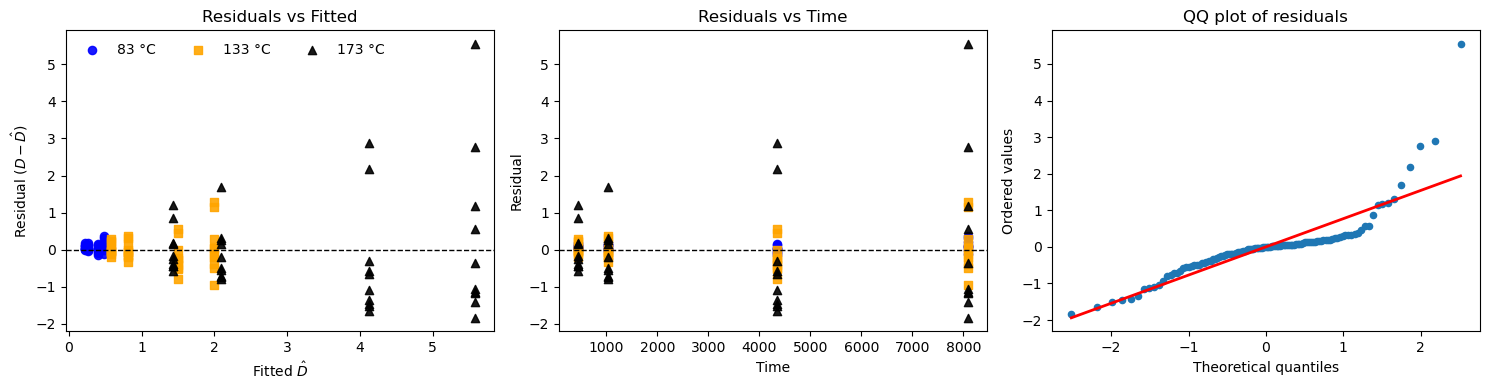

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 102.21it/s]


### Bayesian (multiplicative) Parameter Estimates (95% CrI)

| Parameter | Mean | Median | 95% CrI |
|-----------|------|--------|----------------|
| g0 | 0.269328 | 0.268679 | [0.215556, 0.326805] |
| g1 | 0.000470575 | 0.000457492 | [0.000221864, 0.000740105] |
| Ea (eV) | 0.482892 | 0.48157 | [0.424917, 0.546494] |
| $\sigma$ | 0.309297 | 0.308197 | [0.268876, 0.35181] |

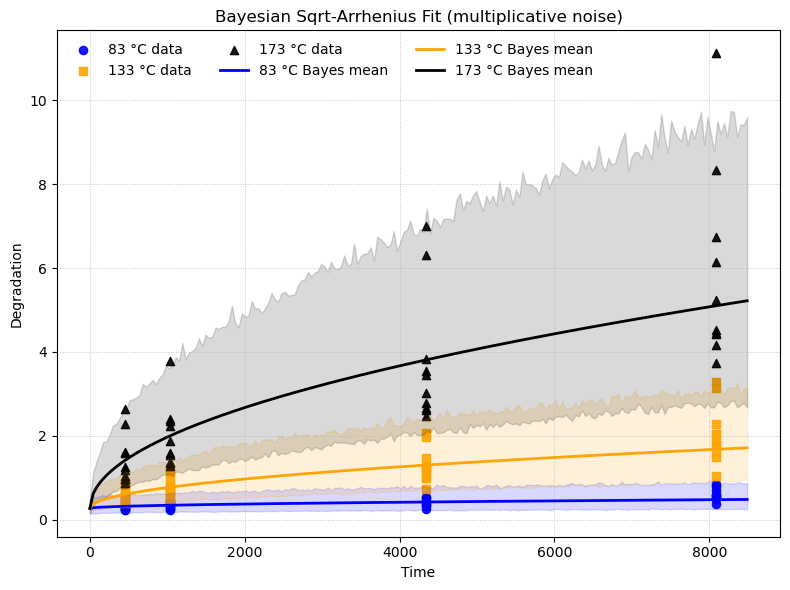

### Posterior summary for TTF at use (Df=5.0) [BAYES]

- Mean life: 1.6623e+08 time units
- Median life: 1.0974e+08 time units
- 95% HDI: [8.0136e+06, 4.8863e+08] time units
- 95% ETI: [2.0516e+07, 6.4843e+08] time units

c:\users\leaat\reliability\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 8000/0 (0% right censored) 

   Distribution       Alpha    Beta       Gamma     Alpha 1  Beta 1     Alpha 2  Beta 2 Proportion 1 DS          Mu       Sigma      Lambda  Log-likelihood   AICc    BIC      AD optimizer
   Lognormal_2P                                                                                             18.5261    0.886547                     -158597 317197 317211 1.20068       TNC
   Lognormal_3P                     1.16251e+06                                                             18.5105    0.900113                     -158593 317193 317214  0.5891       TNC
 Loglogistic_3P  1.0772e+08 1.91931 2.04184e+06                                                                                                     -158668 317342 317363 6.29761       TNC
 Loglogistic_2P 1.10179e+08 1.96766                                                                                                           

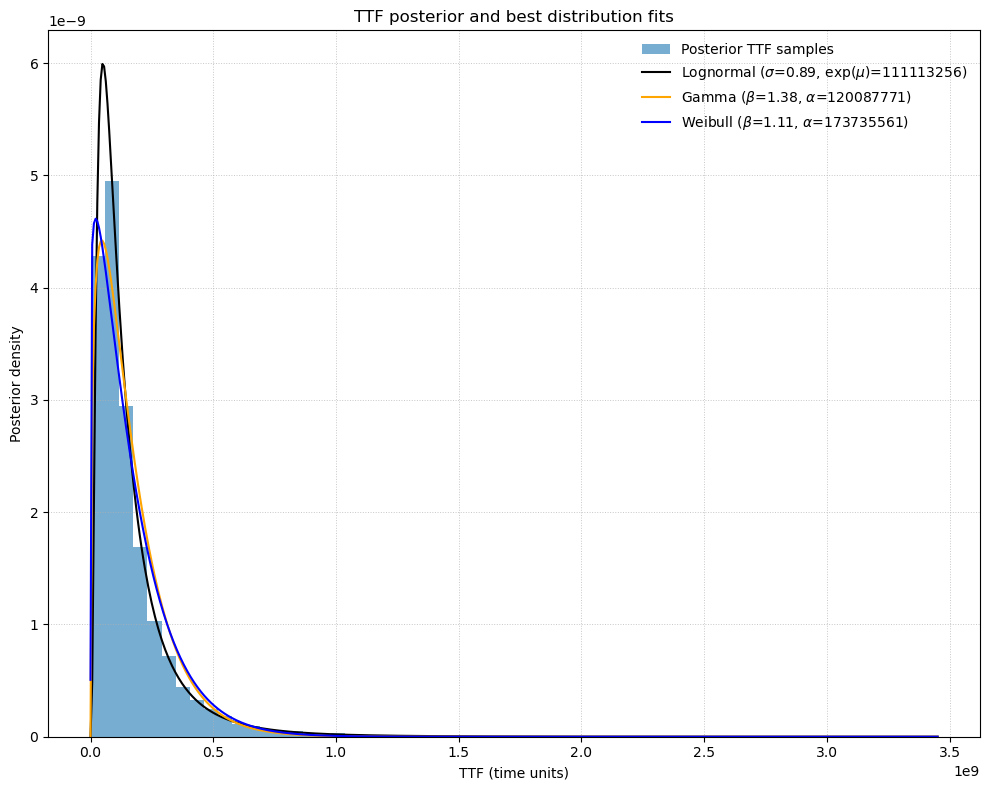

In [47]:
import pandas as pd

df = pd.read_csv("Example_5.2_resistor_data.csv")

# --- Tidy (long) format for plotting ---
time_cols = ['h_452', 'h_1030', 'h_4341', 'h_8084']
time_map = {'h_452': 452, 'h_1030': 1030, 'h_4341': 4341, 'h_8084': 8084}

long = df.melt(
    id_vars=['Unit', 'Temperature_C'],
    value_vars=time_cols,
    var_name='time_label',
    value_name='pct_increase'
).dropna(subset=['pct_increase'])

long['hours'] = long['time_label'].map(time_map).astype(int)
t_time = long["hours"].to_numpy(float)
T_acc_C = long["Temperature_C"].to_numpy(float)
D_obs = long["pct_increase"].to_numpy(float)
T_degC = long["Temperature_C"].to_numpy(float)
unit = long["Unit"].to_numpy()
T_use = 50   # deg C


mle_fit = Fit_ADT_sqrt_Arrhenius(
    degradation=D_obs,
    stress=T_acc_C,
    time=t_time,
    unit = unit,
    stress_use=T_use,
    Df=5,
    CI=0.95,
    method="bayesian",
    # noise="additive",
    noise="multiplicative",
    show_data_plot=False,
    show_LSQ_diagnostics=True,
    show_noise_bounds=True,
    show_use_TTF_dist=True,
    print_results=True)